# 실루엣 분석 (Silhouette Analysis)
1. 아이리스 데이터 클러스티링 평가

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
irisDF = pd.DataFrame(iris.data, columns = ['sl','sw','pl','pw'])
irisDF.head()

,sl,sw,pl,pw
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, random_state = 2021)
kmeans.fit(irisDF)

KMeans(n_clusters=3, random_state=2021)

In [4]:
pd.Series(kmeans.labels_).value_counts()

0    62
1    50
2    38
dtype: int64

In [5]:
irisDF['target'] = iris.target # 실제 target
irisDF['cluster'] = kmeans.labels_ # Clustering 결과
irisDF.head()
# 0과 1로 다 나왔다고 다 틀린것이 아니라 Clustering은 자기 마음대로 labeling을 하기 때문에 일어난 일. 알아볼 수 있기만 하면 된다.

,sl,sw,pl,pw,target,cluster
0,5.1,3.5,1.4,0.2,0,1
1,4.9,3.0,1.4,0.2,0,1
2,4.7,3.2,1.3,0.2,0,1
3,4.6,3.1,1.5,0.2,0,1
4,5.0,3.6,1.4,0.2,0,1


In [6]:
clustering_result = irisDF.groupby(['target','cluster']).count()
clustering_result

sl  sw  pl  pw
target cluster                
0      1        50  50  50  50
1      0        48  48  48  48
       2         2   2   2   2
2      0        14  14  14  14
       2        36  36  36  36

In [15]:
# 각 데이터마다 실루엣 계수를 구함
from sklearn.metrics import silhouette_score, silhouette_samples
# sample은 각 데이터에서 실루엣 계수를 구하는 것
0# score는 그 평균
score_samples = silhouette_samples(iris.data, irisDF.cluster )
irisDF['실루엣 계수'] = score_samples
irisDF.head()

,sl,sw,pl,pw,target,cluster,실루엣 계수
0,5.1,3.5,1.4,0.2,0,1,0.852955
1,4.9,3.0,1.4,0.2,0,1,0.815495
2,4.7,3.2,1.3,0.2,0,1,0.829315
3,4.6,3.1,1.5,0.2,0,1,0.805014
4,5.0,3.6,1.4,0.2,0,1,0.849302


In [18]:
print(silhouette_score(iris.data, irisDF.cluster), irisDF['실루엣 계수'].mean())

0.5528190123564091 0.5528190123564091


In [19]:
clustering_result = irisDF.groupby('cluster')['실루엣 계수'].mean()
clustering_result

cluster
0    0.417320
1    0.798140
2    0.451105
Name: 실루엣 계수, dtype: float64

클러스터별 평균 실루엣 계수 시각화

In [21]:
import matplotlib.cm as cm
import math

def visualize_silhouette(cluster_lists, X_features):    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

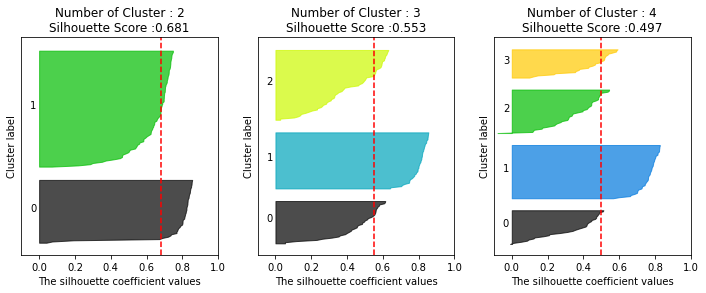

In [22]:
visualize_silhouette([2,3,4], iris.data)

- make_blobs를 통해 만든 가상의 데이터

In [25]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples = 500, n_features = 2, centers = 4,
                  cluster_std = 1, random_state = 2021,
                  center_box = (-10.0,10.0), shuffle=True)
print(X.shape, y.shape)

(500, 2) (500,)


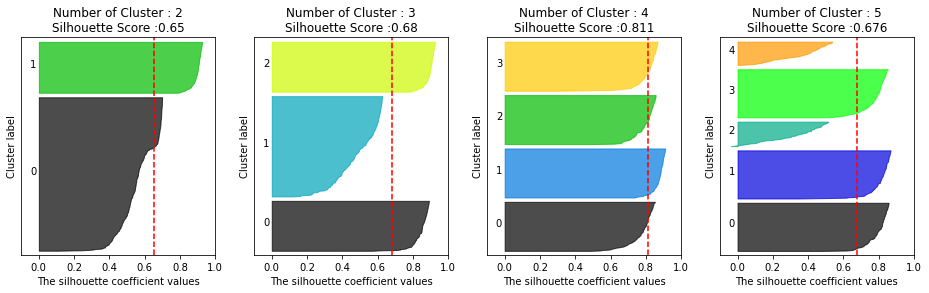

In [27]:
visualize_silhouette([2,3,4,5], X)